> # TODO
>
> - Faster data loading
>   - Convert jpej images to bmp or HDF5
>   - Use **libjpeg-turbo** or **PyVips** or **pillow-simd** to speed up jpeg image I/O from the disk.
>   - Use **albumentations**for GPU utilization.
>   - Try [Nvidia Dali](https://github.com/NVIDIA/DALI) for GPU loading and augmentation
> - Better data
>   - Balance the data
>   - Custom mean and std for the dataset?
> - Better model
>   - Try better models (resnet34, resnet50)
> - Bigger input size (480) using adaptative pooling, final layers then:
>   - -> [AdaptiveAvgPool2d((1, 1))](https://pytorch.org/docs/stable/nn.html#adaptiveavgpool2d) -> Linear
>   - -> Conv2d(512, 4, 3, padding=1) -> AdaptiveAvgPool2d(1) -> view(input.size(0), -1) -> LogSoftmax()
> - Bigger batch size
> - Metrics: mAP
> - Metrics: Confusion matrix
> - Metrics: 10-fold crossvalidation

> # DONE
> - [1 Cycle](https://github.com/nachiket273/One_Cycle_Policy/blob/master/CLR.ipynb) (superconvergence)
> - Use [lr_finder](https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0)
> - 2nd train unfreezed (or partially unfreezed)
> - Fix num_workers = 4  (no es posible en windows)
> - Set validation and test set and train
> - Metrics
>   - Loss
>   - Accuracy

# Import javIA framework

In [1]:
from javIA import *

AI framework by Javi based in PyTorch: 0.4.1


# Load data

OBJETIVO: dataset.shape = (2828, 3, 720, 480)

In [2]:
# Data hyperparameters
csv_file    = pathlib.Path("D:/Datasets/TFM/histologyDS2828/imageClasses.txt")
data_dir    = pathlib.Path("D:/Datasets/TFM/histologyDS2828/imgs")
val_percent = 0.3
num_classes = 4
scale       = 360
input_shape = 480 #224  # 480
mean        = [0.485, 0.456, 0.406] #[0.5, 0.5, 0.5]
std         = [0.229, 0.224, 0.225] #[0.5, 0.5, 0.5]

class histologyDataset(torch.utils.data.Dataset):

	def __init__(self, csv_file, data_dir, subset, limit=False):
		self.df          = pd.read_csv(csv_file, header=None, delim_whitespace=True, names=['Image', 'Label'])
		self.labels      = 'conective', 'ephitelial', 'muscular', 'nervous'
		self.labels_map  = {0: "conective tissue", 1: "ephitelial tissue", 2: "muscular tissue", 3: "nervous tissue"};
		self.data_dir        = data_dir
		self.limit           = limit        
		self.subset          = subset
		self.data_transforms = {
			"train": transforms.Compose([ 
				#transforms.Resize(scale),
				transforms.RandomResizedCrop(input_shape),
				transforms.RandomHorizontalFlip(),
				transforms.RandomVerticalFlip(),
				transforms.RandomRotation(degrees=90),
				transforms.ToTensor(),
				transforms.Normalize(mean, std)]),
			"val": transforms.Compose([
				#transforms.Resize(scale),
				transforms.CenterCrop(input_shape),
				transforms.ToTensor(),
				transforms.Normalize(mean, std)]),
			"show": transforms.Compose([])}

	def __len__(self):
		return len(self.df) if not self.limit else self.limit


	def __getitem__(self, idx):
		if type(idx)==torch.Tensor: idx = idx.item() # bug of WeightedRandomSampler
		img_name = data_dir / (self.df.iloc[idx, 0])
		image    = PIL.Image.open(img_name)
		image    = self.data_transforms[self.subset](image)
		label    = self.df.iloc[idx, 1] - 1
		return image, label

dataset = {x: histologyDataset(csv_file, data_dir, x) for x in ["train", "val", "show"]}
dataset2 = {x: histologyDataset(csv_file, data_dir, x, limit=64) for x in ["train", "val", "show"]}
print("There are", len(dataset["train"]), "images in the dataset.")

There are 2828 images in the dataset.


# Check if data is balanced

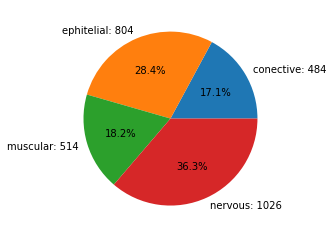

In [3]:
class_counts = plot_balance(dataset["val"])

# Balance data
Create WeightedRandomSampler: The size of the epoch is the same (2828) but now are balanced (undersampling and oversampling)

In [16]:
def get_balanced_sampler(dataset, class_counts):
    class_weights = sum(class_counts)/class_counts
    class_weights2 = 1/class_counts
    
    sample_weights = []
    for idx in range(len(dataset)):
        label = dataset.df.iloc[idx, 1] - 1
        sample_weights.append(class_weights[label])
    
    sample_weights = np.array(sample_weights,dtype='float')
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))
    return sampler

batch_size=8
balanced_sampler = get_balanced_sampler(dataset["train"], class_counts)
trainloader      = torch.utils.data.DataLoader(dataset["train"], batch_size=batch_size, sampler=balanced_sampler)
len(trainloader)*batch_size

2832

In [9]:
for i, (x, y) in enumerate(trainloader):
    print('{}: {}'.format(i, y.numpy()))
    if i == 2: break

0: [3 2 3 0 1 2 2 1]
1: [3 2 1 0 1 3 1 0]
2: [2 0 2 3 0 3 3 2]


# Show data

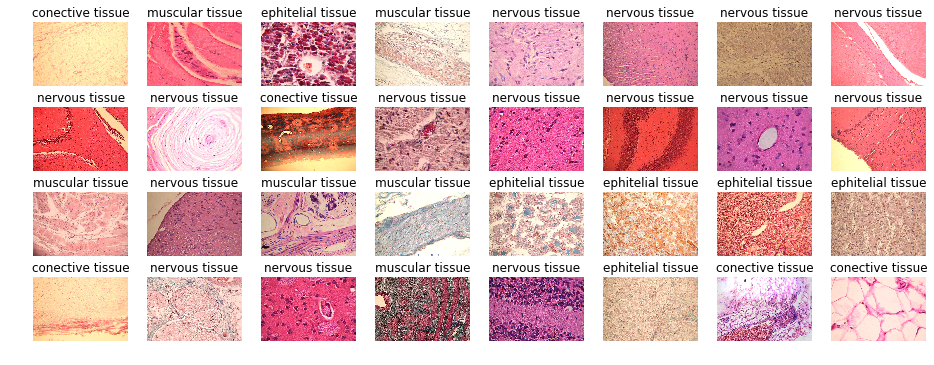

In [4]:
plot_images(dataset["show"])

# Model: Resnet

In [5]:
pretrained     = True
half_precision = True
model          = torchvision.models.resnet18(pretrained=pretrained) # resnet50

freeze(model)

# Edit last 2 layers
model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))                 # for variable image sizes
model.fc      = torch.nn.Linear(model.fc.in_features, num_classes) # new layer unfreezed by default

# Send the model to GPU
model = model.to(device)
if half_precision: model = model.half()

print("Model:")
for i, (name, child) in enumerate(model.named_children()):
    print("\t("+str(i+1)+") "+name)

see_params_to_learn(model)
        
# Loss function
criterion = torch.nn.CrossEntropyLoss()

Model:
	(1) conv1
	(2) bn1
	(3) relu
	(4) maxpool
	(5) layer1
	(6) layer2
	(7) layer3
	(8) layer4
	(9) avgpool
	(10) fc

Params to learn:
	 fc.weight
	 fc.bias


# LR finder

The learning rate finder looks for the optimal learning rate to start the training. The technique is quite simple. For one epoch:

- Start with a very small learning rate (around 1e-8) and increase the learning rate linearly.
- Plot the loss at each step of LR.
- Stop the learning rate finder when loss stops going down and starts increasing.

A graph is created with the x axis having learning rates and the y axis having the losses.

[Webpage 1](https://medium.com/coinmonks/training-neural-networks-upto-10x-faster-3246d84caacd)
[Webpage 2](https://github.com/nachiket273/One_Cycle_Policy/blob/master/CLR.ipynb)

 64%|█████████████████████████████████████████████████████████████████                                    | 29/45 [00:42<00:22,  1.39s/it]

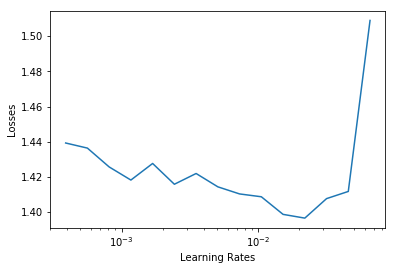

In [6]:
findLR(model, optimizer, criterion, dataloader["train"])

# Train old

In [5]:
learning_rate = 0.01
momentum      = 0.9
weight_decay  = 1e-4
batch_size    = 16 #64

# Optimizer
optimizer = get_optimizer(model, learning_rate, momentum, weight_decay)

Total time: 00:09
Epoch	Trn_loss	Val_loss	Trn_acc		Val_acc
1/5	0.487460	0.000118	0.750000	1.000000   (00:02)
2/5	0.000000	0.000000	1.000000	1.000000   (00:01)
3/5	0.000000	0.000000	1.000000	1.000000   (00:01)
4/5	0.000000	0.000000	1.000000	1.000000   (00:01)
5/5	0.000000	0.000000	1.000000	1.000000   (00:01)

Training complete in 0m 9s
Best val Acc: 1.000000


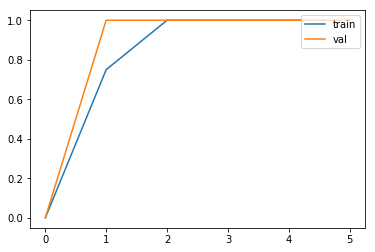

In [6]:
train_old(model, optimizer, criterion, dataset2, batch_size, num_epochs=5, half=half_precision) #4

In [ ]:
unfreeze(model)

In [ ]:
train(num_epochs=3)

# Train

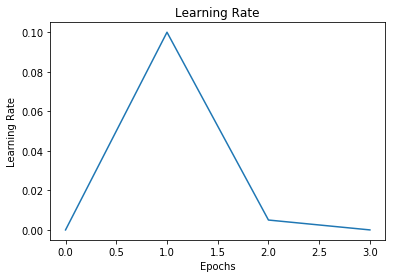

In [7]:
epochs         = [0,1,2,3] #[0, 15, 30, 35]
learning_rates = [0, 0.1, 0.005, 0]
momentum       = [0.95, 0.8, 0.94, 0.95]
num_workers    = 0  # 4 for linux
batch_size     = 64
optimizer      = get_optimizer(model)

plot_lr(epochs, learning_rates)

Total time: 03:34
Epoch	Time	LearRate	T_loss	T_accu		V_loss	V_accu                      
----------------------------------------------------------------------
1/3	1:12	0.1000		0.0213	0.3667		0.0177	0.5410                           (01:12)
2/3	2:24	0.0050		0.0170	0.5477		0.0151	0.6559                           (01:11)
3/3	3:35	0.0000		0.0162	0.5905		0.0151	0.6623                           (01:11)



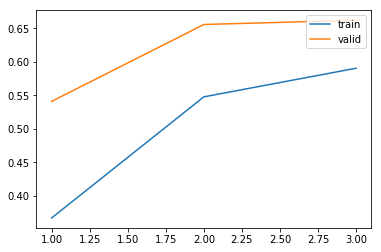

In [8]:
summary = train(model, epochs, learning_rates, optimizer, criterion, dataset, batch_size)

Total time: 03:32
Epoch	Time	LearRate	T_loss	T_accu		V_loss	V_accu                      
----------------------------------------------------------------------
1/3	1:11	0.1000		0.0159	0.6124		0.0138	0.7076                           (01:11)
2/3	2:22	0.0050		0.0148	0.6421		0.0128	0.7366                           (01:10)
3/3	3:33	0.0000		0.0143	0.6584		0.0127	0.7291                           (01:10)



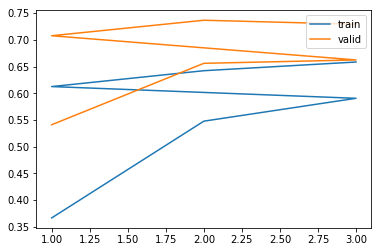

In [11]:
unfreeze(model)
summary = train(model, epochs, learning_rates, optimizer, criterion, dataset, batch_size)

# Buscar cuellos de botella

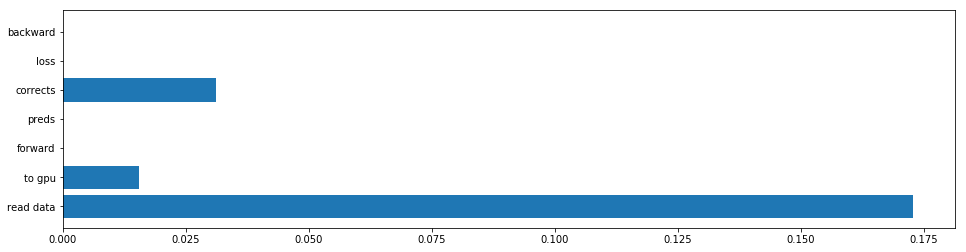

In [6]:
dataloader = torch.utils.data.DataLoader(dataset["train"], batch_size, shuffle=True)
plot_bottleneck(model, criterion, optimizer, dataloader, batch_size)

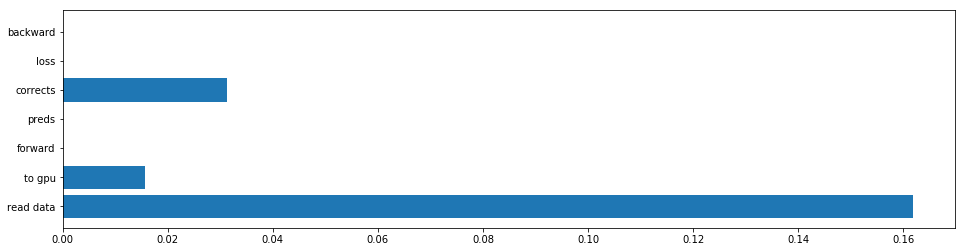

In [9]:
plot_bottleneck(model, criterion, optimizer, dataloader, batch_size)

# Confusion matrix

In [ ]:
plot_confusion(model, dataset)